# MNIST

Notebook to compare models for handwritten digit classification (MNIST).

Use `scripts/simulate_examples.py` to visualize embeddings and learned PSFs.

In [12]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMClassifier, SingleHidden
from lenslessclass.datasets import Augmented
from lenslessclass.model_dict import model_dict
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib
import os


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
linewidth = 3
markersize = 200


MODEL_DIR = "../models/mnist"
models = model_dict["MNIST"]


markers_dict = {
    "Lens": "o",
    "Coded aperture": "s",
    "Diffuser": "X",
    "Fixed mask (m)": "^",
    "Fixed mask (s)": "v",
    "Learned mask": "D",
}
color_dict = {
    "Lens": "darkorange",
    "Coded aperture": "red",
    "Diffuser": "deeppink",
    "Fixed mask (m)": "purple",
    "Fixed mask (s)": "blue",
    "Learned mask": "g",
}

markers = ["o", "s", "D", "P", "X", "v",  "<", ">", "D", ".", "1", "2", "3", "4", "8"]
linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1))]

# accuracy curves

Original, LR, 24x32 - best accuracy in 50 epochs : 0.927
Original, LR, 12x16 - best accuracy in 50 epochs : 0.918
Original, LR, 6x8 - best accuracy in 50 epochs : 0.865
Original, LR, 3x4 - best accuracy in 50 epochs : 0.727
Original, FCNN, 24x32 - best accuracy in 50 epochs : 0.986
Original, FCNN, 12x16 - best accuracy in 50 epochs : 0.987
Original, FCNN, 6x8 - best accuracy in 50 epochs : 0.975
Original, FCNN, 3x4 - best accuracy in 50 epochs : 0.886
Shift, FCNN, 24x32 - best accuracy in 50 epochs : 0.379
Rescale, FCNN, 24x32 - best accuracy in 50 epochs : 0.968
Rotate, FCNN, 24x32 - best accuracy in 50 epochs : 0.955
Perspective, FCNN, 24x32 - best accuracy in 50 epochs : 0.791
no saved plot


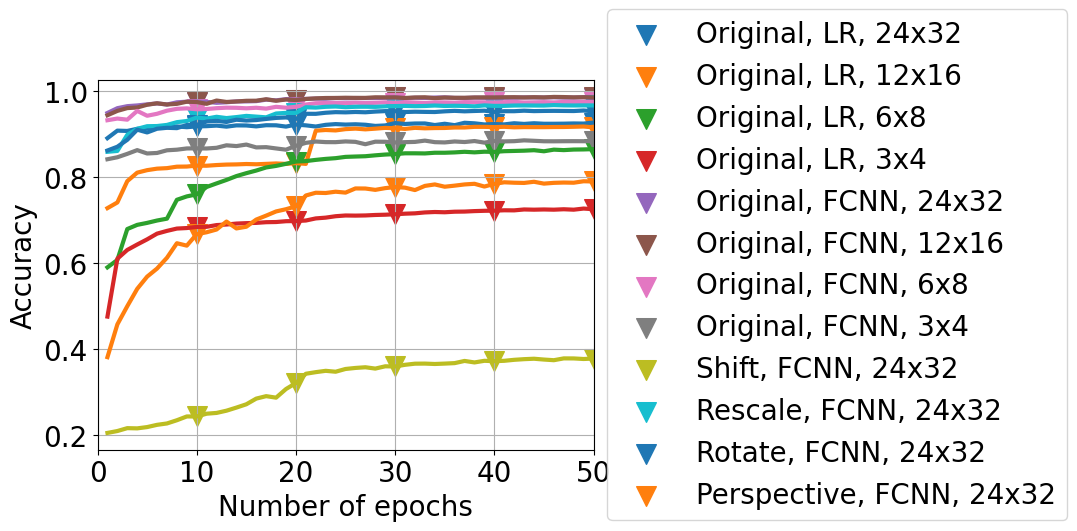

In [13]:
MAX_EPOCH = 50
every = 10
plot_train = False

cam_filt = None
cam_filt = ["Fixed mask (s)"]
arch_filt = None
# arch_filt = ["LR"]
perturb_filt = None
# perturb_filt = ["Rescale"]
dim_filt = None
# dim_filt = ["24x32"]


ax = plt.subplot(111)
for cam in models.keys():
    if cam_filt is not None and cam not in cam_filt:
        continue
    for arch in models[cam].keys():
        if arch_filt is not None and arch not in arch_filt:
            continue
        for perturb in models[cam][arch].keys():
            if perturb_filt is not None and perturb not in perturb_filt:
                continue
            for dim in models[cam][arch][perturb].keys():
                if dim_filt is not None and dim not in dim_filt:
                    continue
                _label = []
                if cam_filt is None or len(cam_filt) > 1:
                    _label += [cam]
                if perturb_filt is None or len(perturb_filt) > 1:
                    _label += [perturb]
                if arch_filt is None or len(arch_filt) > 1:
                    _label += [arch]
                if dim_filt is None or len(dim_filt) > 1:
                    _label += [dim]

                _label = ", ".join(_label)
                model_path = MODEL_DIR / models[cam][arch][perturb][dim]
                
                test_acc_fp = str(plib.Path(model_path) / "test_acc.npy")
                if os.path.exists(test_acc_fp):
                    test_acc = np.load(test_acc_fp)
                    n_epoch = np.arange(len(test_acc)) + 1
                    print(f"{_label} - best accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(test_acc[:MAX_EPOCH]), 3)}")
                    line, = plt.plot(n_epoch,  test_acc, linewidth=linewidth, linestyle="-")
                    ax.scatter(n_epoch[every-1::every], test_acc[every-1::every], marker=markers_dict[cam], s=markersize, c=line.get_color(), label=_label)
                else:
                    print(f"{_label} - {test_acc_fp} does not exist")

                if plot_train:
                    train_acc_fp = str(plib.Path(model_path) / "train_acc.npy")
                    if os.path.exists(train_acc_fp):
                        train_acc = np.load(train_acc_fp)
                        n_epoch = np.arange(len(train_acc)) + 1
                        print(f"{_label} - best *train* accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(train_acc[:MAX_EPOCH]), 3)}")
                        plt.plot(n_epoch,  train_acc, c=line.get_color(), label=_label + ", train", linestyle="--", linewidth=linewidth)
            
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.grid()

try:
    if len(arch_filt) == 1 and len(dim_filt) == 1 and len(perturb_filt) == 1:
        fp = f"{arch_filt[0]}_{dim_filt[0]}_{perturb_filt[0]}.png"
        plt.savefig(fp, bbox_inches='tight')
        print("plot saved to ", fp)
except:
    print("no saved plot")


# loss curves

Lens - best loss in 50 epochs : 1.478
Lens - best *train* loss in 50 epochs : 1.473
Coded aperture - best loss in 50 epochs : 1.485
Coded aperture - best *train* loss in 50 epochs : 1.492
Diffuser - best loss in 50 epochs : 1.476
Diffuser - best *train* loss in 50 epochs : 1.473
Fixed mask (m) - best loss in 50 epochs : 1.475
Fixed mask (m) - best *train* loss in 50 epochs : 1.474
Fixed mask (s) - best loss in 50 epochs : 1.475
Fixed mask (s) - best *train* loss in 50 epochs : 1.474
Learned mask - best loss in 50 epochs : 1.475
Learned mask - best *train* loss in 50 epochs : 1.47


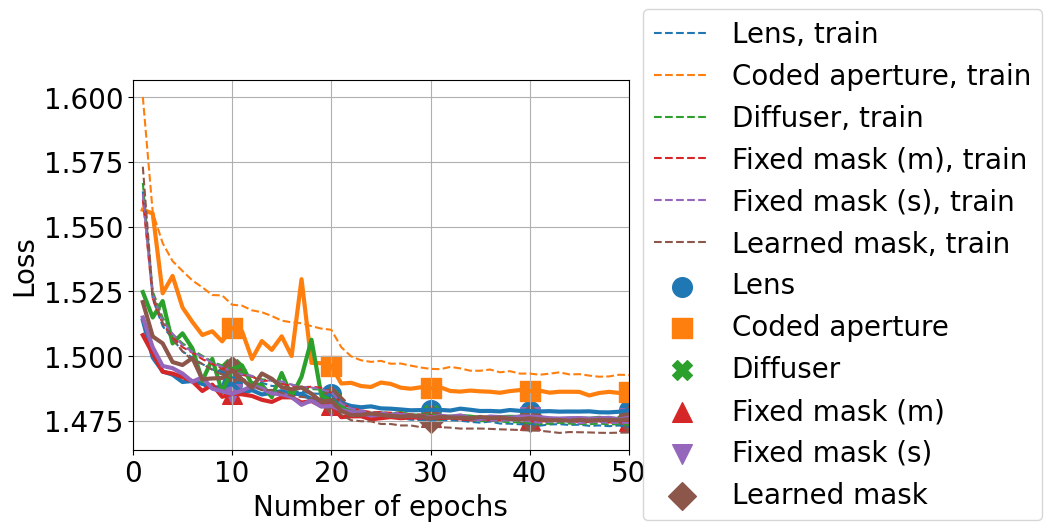

In [14]:
MAX_EPOCH = 50
every = 10
plot_train = True

cam_filt = None
# cam_filt = ["Lens"]
arch_filt = None
arch_filt = ["FCNN"]
perturb_filt = None
perturb_filt = ["Original"]
dim_filt = None
dim_filt = ["24x32"]


ax = plt.subplot(111)
for cam in models.keys():
    if cam_filt is not None and cam not in cam_filt:
        continue
    for arch in models[cam].keys():
        if arch_filt is not None and arch not in arch_filt:
            continue
        for perturb in models[cam][arch].keys():
            if perturb_filt is not None and perturb not in perturb_filt:
                continue
            for dim in models[cam][arch][perturb].keys():
                if dim_filt is not None and dim not in dim_filt:
                    continue
                _label = []
                if cam_filt is None or len(cam_filt) > 1:
                    _label += [cam]
                if perturb_filt is None or len(perturb_filt) > 1:
                    _label += [perturb]
                if arch_filt is None or len(arch_filt) > 1:
                    _label += [arch]
                if dim_filt is None or len(dim_filt) > 1:
                    _label += [dim]

                _label = ", ".join(_label)
                model_path = MODEL_DIR / models[cam][arch][perturb][dim]
                
                test_loss_fp = str(plib.Path(model_path) / "test_loss.npy")
                if os.path.exists(test_loss_fp):
                    test_loss = np.load(test_loss_fp)
                    n_epoch = np.arange(len(test_loss)) + 1
                    print(f"{_label} - best loss in {min(MAX_EPOCH, len(test_loss))} epochs : {round(np.min(test_loss[:MAX_EPOCH]), 3)}")
                    line, = plt.plot(n_epoch,  test_loss, linewidth=linewidth, linestyle="-")
                    ax.scatter(n_epoch[every-1::every], test_loss[every-1::every], marker=markers_dict[cam], s=markersize, c=line.get_color(), label=_label)
                else:
                    print(f"{_label} - {test_loss_fp} does not exist")

                if plot_train:
                    train_loss_fp = str(plib.Path(model_path) / "train_loss.npy")
                    if os.path.exists(train_loss_fp):
                        train_loss = np.load(train_loss_fp)
                        n_epoch = np.arange(len(train_loss)) + 1
                        print(f"{_label} - best *train* loss in {min(MAX_EPOCH, len(train_loss))} epochs : {round(np.min(train_loss[:MAX_EPOCH]), 3)}")
                        plt.plot(n_epoch,  train_loss, c=line.get_color(), label=_label + ", train", linestyle="--")
            
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.grid()

# performance drops

from (24x32) to (3x4)

In [15]:
# compute performance drop from lower resolution
for cam in models.keys():
    for arch in models[cam].keys():
        model_dict = models[cam][arch]["Original"]
        fp1 = str(MODEL_DIR / plib.Path(model_dict["24x32"]) / "test_acc.npy")
        fp2 = str(MODEL_DIR / plib.Path(model_dict["3x4"]) / "test_acc.npy")
        if os.path.exists(fp1) and os.path.exists(fp2):
            val1 = np.max(np.load(fp1))
            val2 = np.max(np.load(fp2))
            drop = 1. - val2 / val1
            print(f"{cam}, {arch} : {round(drop, 3) * 100}")

Lens, LR : 76.3
Lens, FCNN : 77.10000000000001
Coded aperture, LR : 30.5
Coded aperture, FCNN : 27.200000000000003
Diffuser, LR : 40.6
Diffuser, FCNN : 20.0
Fixed mask (m), LR : 21.0
Fixed mask (m), FCNN : 11.4
Fixed mask (s), LR : 21.6
Fixed mask (s), FCNN : 10.2
Learned mask, LR : 17.0
Learned mask, FCNN : 7.1


due to each perturbation

In [16]:
# performance drop from perturbations
arch = "FCNN"
dim = "24x32"

for cam in models.keys():
    for pert in models[cam][arch].keys():
        model_dict = models[cam][arch]
        fp1 = str(MODEL_DIR / plib.Path(model_dict["Original"][dim]) / "test_acc.npy")
        fp2 = str(MODEL_DIR / plib.Path(model_dict[pert][dim]) / "test_acc.npy")
        if os.path.exists(fp1) and os.path.exists(fp2):
            val1 = np.max(np.load(fp1))
            val2 = np.max(np.load(fp2))
            drop = 1. - val2 / val1
            print(f"{cam}, {pert} : {round(drop, 3) * 100}")

Lens, Original : 0.0
Lens, Shift : 12.1
Lens, Rescale : 13.5
Lens, Rotate : 3.3000000000000003
Lens, Perspective : 13.5
Coded aperture, Original : 0.0
Coded aperture, Shift : 77.2
Coded aperture, Rescale : 15.299999999999999
Coded aperture, Rotate : 6.800000000000001
Coded aperture, Perspective : 67.9
Diffuser, Original : 0.0
Diffuser, Shift : 67.80000000000001
Diffuser, Rescale : 2.1999999999999997
Diffuser, Rotate : 3.0
Diffuser, Perspective : 27.6
Fixed mask (m), Original : 0.0
Fixed mask (m), Shift : 56.699999999999996
Fixed mask (m), Rescale : 2.0
Fixed mask (m), Rotate : 3.2
Fixed mask (m), Perspective : 18.3
Fixed mask (s), Original : 0.0
Fixed mask (s), Shift : 61.6
Fixed mask (s), Rescale : 1.9
Fixed mask (s), Rotate : 3.1
Fixed mask (s), Perspective : 19.8
Learned mask, Original : 0.0
Learned mask, Shift : 30.4
Learned mask, Rescale : 6.4
Learned mask, Rotate : 3.0
Learned mask, Perspective : 14.399999999999999


# confusion matrix

In [17]:
DATA_DIR = "../data"  # to overwrite parent directory in metadata of model

model_dir = MODEL_DIR / plib.Path(models["Learned mask"]["FCNN"]["Original"]["24x32"])
model_dir = MODEL_DIR / plib.Path(models["Fixed mask (s)"]["FCNN"]["Original"]["24x32"])

f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
# pprint(metadata)

In [18]:
from lenslessclass.models import SLMClassifier


# load model
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")


if "SLM" in metadata["model"]:

    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
            "multi_gpu": [0, 1] if metadata["model_param"]["multi_gpu"] else False,
        }
    )
    model = SLMClassifier(**metadata["model_param"])
    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))

    # recompute PSF for loaded SLM values
    model.grayscale = True
    model.compute_intensity_psf()

    device = model.device

else:

    if metadata["hidden_dim"]:
        model = SingleHidden(
            input_shape=metadata["output_dim"],
            hidden_dim=metadata["hidden_dim"][0],
            n_class=10,
        )

    else:
        model = MultiClassLogistic(input_shape=metadata["output_dim"], n_class=10)

    if metadata["model_param"]["multi_gpu"]:
        model = nn.DataParallel(model, device_ids=metadata["model_param"]["multi_gpu"])

    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))


CUDA available, using GPU.


In [19]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
module.linear1.weight 	 torch.Size([800, 768])
module.bn1.weight 	 torch.Size([800])
module.bn1.bias 	 torch.Size([800])
module.bn1.running_mean 	 torch.Size([800])
module.bn1.running_var 	 torch.Size([800])
module.bn1.num_batches_tracked 	 torch.Size([])
module.linear2.weight 	 torch.Size([10, 800])
module.linear2.bias 	 torch.Size([10])


In [20]:
_path = DATA_DIR / plib.Path(os.path.basename(metadata["dataset"]))
print(_path)

# load test set
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
test_set = Augmented(path=_path, train=False, transform=trans)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)

../data/MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0


In [21]:
# compute accuracy
criterion = nn.CrossEntropyLoss().to(device)

y_pred = []
y_true = []
correct_cnt, running_loss = 0, 0
total_cnt = 0

model.eval()
with torch.no_grad():
    for x, target in test_loader:

        # get inputs
        if use_cuda:
            x, target = x.to(device=device), target.to(device=device)

        if "min_val" in metadata.keys():
            x -= metadata["min_val"]

        # forward, and compute loss
        out = model(x).to(device=device)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        pred_label = pred_label.to(device=device)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()

        # save prediction and true for confusion matrix
        y_pred.extend(pred_label.data.cpu().numpy()) # Save Prediction
        y_true.extend(target.data.cpu().numpy())

acc = (correct_cnt * 1.0 / total_cnt).item()
print("acc: {:.3f}".format(acc))
print('Class distribution: %s' % np.bincount(y_true))

acc: 0.986
Class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


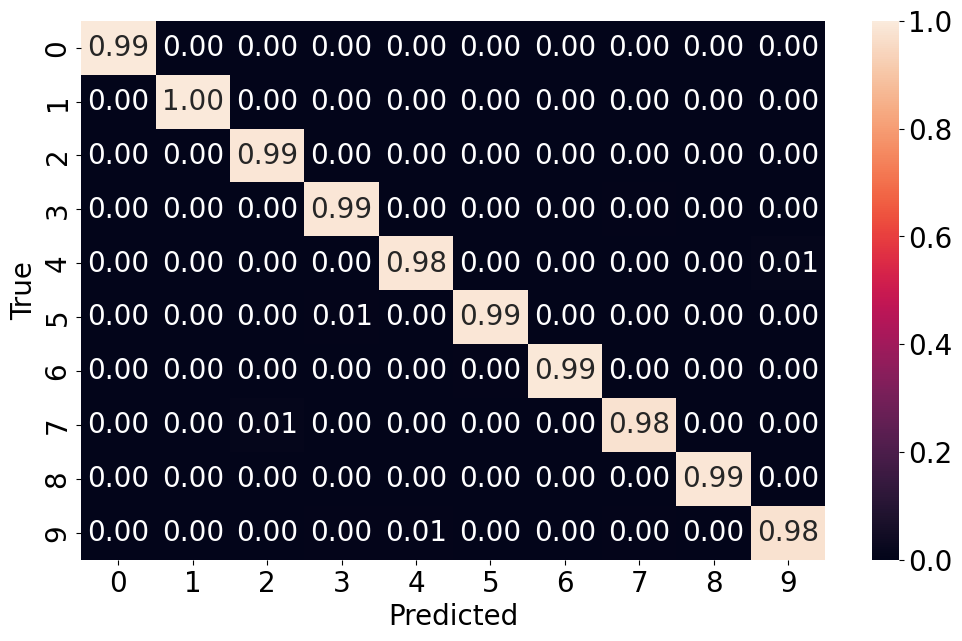

In [22]:
# Build confusion matrix
classes = np.arange(10)
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".2f", vmin=0, vmax=1)
plt.ylabel("True")
plt.xlabel("Predicted");